### Download fastText and facebook infersent models
Followed steps at: https://github.com/facebookresearch/InferSent

In [3]:
import nltk
nltk.download('punkt')
import sys
sys.path.append("../lib/InferSent")
from models import InferSent
# import torch
import pandas as pd
import spacy
import numpy as np
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /Users/chendeen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load('../models/encoder/infersent2.pkl'))
infersent.set_w2v_path("../models/fastText/crawl-300d-2M.vec")

In [5]:
squad_df = pd.read_csv("../corpora/squad-dev-v2.0.csv", index_col=0)
squad_df.head()

,contexts,questions,answer_texts,answer_starts
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94
2,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,in the 10th and 11th centuries,87
3,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256
4,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308


In [6]:
pd.set_option('max_colwidth', 100)
squad_df.sample(5)

,contexts,questions,answer_texts,answer_starts
4128,The development of plate tectonics provided a physical basis for many observations of the solid ...,What is the area called where two plates move apart?,divergent boundaries,295
9889,"The British failures in North America, combined with other failures in the European theater, led...",How many of the Pitt's planned expeditions were successful?,Two,641
9707,The Iroquois sent runners to the manor of William Johnson in upstate New York. The British Super...,What title did Iroquois give Johnson?,He who does great things,220
8325,Reserved matters are subjects that are outside the legislative competence of the Scotland Parlia...,Most aspects of transport safety is a subject dealt with by whom?,UK Government ministers,267
10316,Newton's laws and Newtonian mechanics in general were first developed to describe how forces aff...,What didn't Newton's mechanics affext?,three-dimensional objects,138


In [7]:
# nlp = spacy.load("en")
nlp = spacy.load("en_core_web_sm")

In [8]:
sentences = []

contexts = list(squad_df["contexts"].drop_duplicates())
for context in contexts:
    doc = nlp(context)
    sentences += [sentence.text.strip() for sentence in doc.sents]
    # sentences += [sentence.string.strip() for sentence in doc.sents]

In [9]:
infersent.build_vocab(sentences, tokenize=True)

Found 18482(/19810) words with w2v vectors
Vocab size : 18482


In [10]:
embeddings = infersent.encode(sentences, tokenize=True)

../lib/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


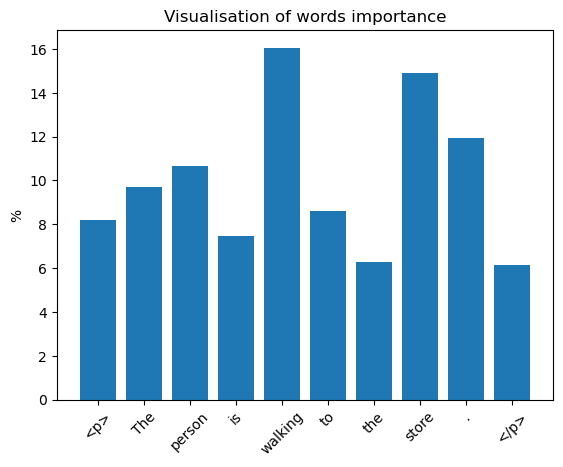

(tensor([[ 7.4689e-03, -2.8139e-02,  6.8252e-02,  ..., -1.7070e-02,
          -3.3051e-02, -8.4244e-03]], grad_fn=<MaxBackward0>),
 array([[0, 2, 4, ..., 7, 5, 1]]))

In [11]:
infersent.visualize('The person is walking to the store.', tokenize=True)

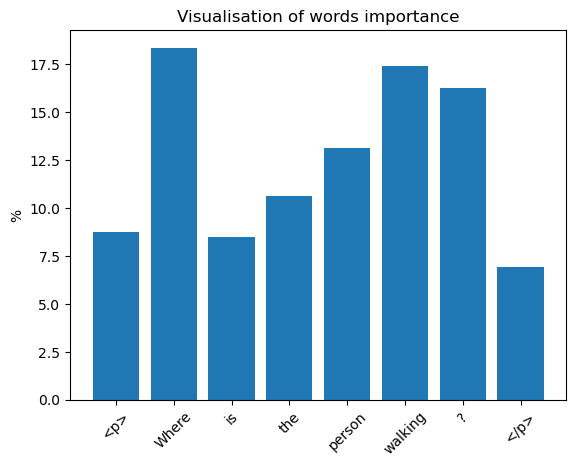

(tensor([[ 7.4689e-03, -2.9244e-02,  5.5140e-02,  ..., -5.4694e-03,
          -3.5621e-02, -1.9324e-02]], grad_fn=<MaxBackward0>),
 array([[0, 1, 5, ..., 3, 6, 1]]))

In [12]:
infersent.visualize('Where is the person walking?', tokenize=True)

In [13]:
def cosine_similarity(text1, text2):
    return np.dot(text1, text2)/(np.linalg.norm(text1) * np.linalg.norm(text2))

In [19]:
def split_sentences(paragraph):
    doc = nlp(paragraph)
    return [sentence.text.strip() for sentence in doc.sents]
    # return [sentence.string.strip() for sentence in doc.sents]

In [20]:
def cosine_predict(statements, question):
    context_sentences = split_sentences(statements)
    most_similar, highest_sim = "", 0
    for sentence in context_sentences:
        similarity = cosine_similarity(infersent.encode([question])[0], infersent.encode([sentence])[0])
        if similarity > highest_sim:
            most_similar = sentence
            highest_sim = similarity
    return most_similar, highest_sim

In [21]:
len(squad_df)

10388

In [22]:
# 这个block的运行不会影响之后的
sample_size = len(squad_df) # 10388
correct_answers = 0
for i, row in tqdm(squad_df.iterrows(), total=sample_size):
    most_similar, _ = cosine_predict(row["contexts"], row["questions"])    
    correct_answers += 1 if row["answer_texts"] in most_similar else 0
print(f"Cosine Similarity Accuracy: {correct_answers/sample_size}")

  0%|          | 0/10388 [00:00<?, ?it/s]

In [ ]:
# sample = squad_df.sample(n=1).iloc(0)[0]
sample = squad_df.iloc[7629]
sample.head()

contexts         Prime numbers have influenced many artists and writers. The French composer Olivier Messiaen use...
questions                                           Which French composer wrote ametrical music using prime numbers?
answer_texts                                                                                        Olivier Messiaen
answer_starts                                                                                                     76
Name: 7629, dtype: object

In [ ]:
sample.contexts

'Prime numbers have influenced many artists and writers. The French composer Olivier Messiaen used prime numbers to create ametrical music through "natural phenomena". In works such as La Nativité du Seigneur (1935) and Quatre études de rythme (1949–50), he simultaneously employs motifs with lengths given by different prime numbers to create unpredictable rhythms: the primes 41, 43, 47 and 53 appear in the third étude, "Neumes rythmiques". According to Messiaen this way of composing was "inspired by the movements of nature, movements of free and unequal durations".'

In [ ]:
statements = split_sentences(sample["contexts"])
options = {"compact": True, "bg": "#323a48", "color": "white", "font": "Source Sans Pro"}
spacy.displacy.render(nlp(statements[0]), style="dep", options=options)

In [ ]:
statements

['Prime numbers have influenced many artists and writers.',
 'The French composer Olivier Messiaen used prime numbers to create ametrical music through "natural phenomena".',
 'In works such as La Nativité du Seigneur (1935) and Quatre études de rythme (1949–50), he simultaneously employs motifs with lengths given by different prime numbers to create unpredictable rhythms: the primes 41, 43, 47 and 53 appear in the third étude, "Neumes rythmiques".',
 'According to Messiaen this way of composing was "inspired by the movements of nature, movements of free and unequal durations".']

In [ ]:
cosine_predict(sample.contexts, sample.questions)

('The French composer Olivier Messiaen used prime numbers to create ametrical music through "natural phenomena".',
 0.73706377)

In [ ]:
statements = "The air was cold. The cat was orange. The cat walked across the grass. A bird flew in the sky."
question = "Where did the cat walk?"
cosine_predict(statements, question)

('The cat walked across the grass.', 0.48702255)

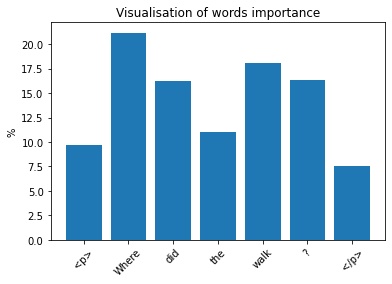

(tensor([[ 0.0075, -0.0292,  0.0664,  ...,  0.0401,  0.0146, -0.0329]],
        grad_fn=<MaxBackward0>),
 array([[0, 1, 4, ..., 2, 4, 5]]))

In [ ]:
infersent.visualize(question, tokenize=True)

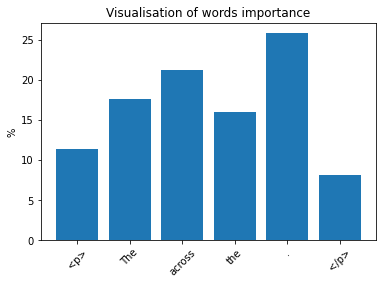

(tensor([[ 0.0075, -0.0695,  0.0447,  ..., -0.0573,  0.0130, -0.0139]],
        grad_fn=<MaxBackward0>),
 array([[0, 1, 2, ..., 2, 2, 4]]))

In [ ]:
infersent.visualize("The cat walked across the grass.", tokenize=True)

In [ ]:
# TODO: Random Forest, Log Regression, RNN, AWD-LSTM, Make class for QA model to seed chatbot text gen